In [1]:
# Importing Required Libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
# Initialize the training and validation generators
train_dir = 'train'
test_dir = 'test'
train_datagenerator = ImageDataGenerator(rescale=1./255)
test_datagenerator = ImageDataGenerator(rescale=1./255)

train_generator = train_datagenerator.flow_from_directory(
        train_dir,
        target_size=(48,48),
        batch_size=64,
        color_mode="grayscale",
        class_mode='categorical')

test_generator = test_datagenerator.flow_from_directory(
        test_dir,
        target_size=(48,48),
        batch_size=64,
        color_mode="grayscale",
        class_mode='categorical')

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [3]:
# Building the CNN architecture
# with four conv2D layers, two dense layers and one flatten layer
recognition_model = Sequential()

recognition_model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(48,48,1)))
recognition_model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
recognition_model.add(MaxPooling2D(pool_size=(2, 2)))
recognition_model.add(Dropout(0.25))

recognition_model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
recognition_model.add(MaxPooling2D(pool_size=(2, 2)))
recognition_model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
recognition_model.add(MaxPooling2D(pool_size=(2, 2)))
recognition_model.add(Dropout(0.25))

recognition_model.add(Flatten())
recognition_model.add(Dense(1024, activation='relu'))
recognition_model.add(Dropout(0.5))
recognition_model.add(Dense(7, activation='softmax'))

In [4]:
# Getting Model Summary
recognition_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 44, 44, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 22, 22, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 22, 22, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 20, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 10, 128)      0         
 2D)                                                    

In [5]:
# Disable OpenCL
cv2.ocl.setUseOpenCL(False)

In [6]:
# Define the learning rate schedule
initial_learning_rate = 0.0001
lr_schedule = ExponentialDecay(initial_learning_rate, decay_steps=10000, decay_rate=0.96)


In [7]:
# Compile Model
recognition_model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=lr_schedule), metrics=['accuracy'])


In [8]:
# Train the model
recognition_model_info = recognition_model.fit(
        train_generator,
        steps_per_epoch=28709 // 64,
        epochs=50,
        validation_data=test_generator,
        validation_steps=7178 // 64)

Epoch 1/50
448/448 [==============================] - 217s 476ms/step - loss: 1.7944 - accuracy: 0.2676 - val_loss: 1.6826 - val_accuracy: 0.3563
Epoch 2/50
448/448 [==============================] - 257s 573ms/step - loss: 1.6278 - accuracy: 0.3662 - val_loss: 1.5608 - val_accuracy: 0.4086
Epoch 3/50
448/448 [==============================] - 257s 572ms/step - loss: 1.5485 - accuracy: 0.4055 - val_loss: 1.4786 - val_accuracy: 0.4301
Epoch 4/50
448/448 [==============================] - 229s 510ms/step - loss: 1.4755 - accuracy: 0.4338 - val_loss: 1.4147 - val_accuracy: 0.4633
Epoch 5/50
448/448 [==============================] - 189s 423ms/step - loss: 1.4159 - accuracy: 0.4595 - val_loss: 1.3611 - val_accuracy: 0.4823
Epoch 6/50
448/448 [==============================] - 182s 406ms/step - loss: 1.3621 - accuracy: 0.4832 - val_loss: 1.3171 - val_accuracy: 0.5004
Epoch 7/50
448/448 [==============================] - 182s 406ms/step - loss: 1.3181 - accuracy: 0.5034 - val_loss: 1.2813 -

In [9]:
# Saving the trained Model Weights
recognition_model.save_weights('recognition_model.h5')

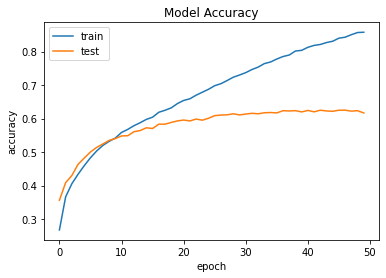

In [10]:
# Summarize history for accuracy
plt.title('Model Accuracy')
plt.plot(recognition_model_info.history['accuracy'])
plt.plot(recognition_model_info.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

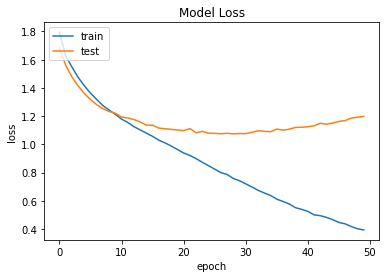

In [11]:
# Summarize history for loss
plt.title('Model Loss')
plt.plot(recognition_model_info.history['loss'])
plt.plot(recognition_model_info.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [12]:
# For detecting bounding boxes of face in the webcam and
# to predict the emotions we use OpenCV Haarcascade xml:

# Facial emotion Dictonary with values
facial_dict = {0: "Angry", 1: "Disgusted", 2: "Fearful", 3: "Happy", 4: "Neutral", 5: "Sad", 6: "Surprised"}


In [13]:
# Start the webcam feed
cap = cv2.VideoCapture(0)

In [14]:
while True:
    # Find haar cascade to draw bounding box around face
    ret, frame = cap.read()
    if not ret:
        break
   # bounding_box = cv2.CascadeClassifier('haarcascades_cuda/haarcascade_frontalface_default.xml')
    bounding_box = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    num_faces = bounding_box.detectMultiScale(gray_frame,scaleFactor=1.3, minNeighbors=5)
    
    for (x, y, w, h) in num_faces:
        cv2.rectangle(frame, (x, y-50), (x+w, y+h+10), (255, 0, 0), 2)
        roi_gray_frame = gray_frame[y:y + h, x:x + w]
        cropped_img = np.expand_dims(np.expand_dims(cv2.resize(roi_gray_frame, (48, 48)), -1), 0)
        facial_prediction = recognition_model.predict(cropped_img)
        maxindex = int(np.argmax(facial_prediction))
        cv2.putText(frame, facial_dict[maxindex], (x+20, y-60), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

    cv2.imshow('Video', cv2.resize(frame,(1200,860),interpolation = cv2.INTER_CUBIC))
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 32ms/step
